# Datamining 7331 Minilab: Analysis of Airbnb data using Logistic Regression and SVM

By: William Arnost, Stephen Johnson, Sean Kennedy, Tazeb Abera

## Introduction

In this notebook we will be predicting the room type feature from the Airbnb data set using Logistic Regression and Support Vector Machines. Room type can take 3 values: 'Private room', 'Entire home/apt', and 'Shared room'. Room type by itself might not be a useful thing to predict, but we are hoping this can teach us something about our data for a future price prediction exercise. We will compare accuracy between the two algorithms, as well as look at hyperparameter tuning for each one. Then we discuss which model was more useful and look at the interpretation of the features. 

---
## Contents

* <a href="#DataPreperation">Data Preperation</a>
* <a href="#CreateModels">Create Models</a>
* <a href="#ModelAdvantages">Model Advantages</a>
* <a href="#InterpretFeatureImportance">Interpret Feature Importance</a>
* <a href="#InterpretSupportVectors">Interpret Support Vectors</a>
* <a href="#Conclusion">Conclusion</a>



---
<a id="Loading"></a>
<a href="#top">Back to Top</a>

<a id="DataPreperation"></a>
# Data Preperation

This section is where we load and prepare our data. This was not part of the grading rubric so we do not present any modeling or analysis here.

### Package Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
#sns.set(style="ticks", color_codes=True)
# sklearn stuff
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#yellobrick stuff
from yellowbrick.classifier import ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ClassificationReport, ClassPredictionError, ROCAUC
from yellowbrick.target import ClassBalance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Define Functions for model analysis

In [2]:
def analyze_classifier(model,
                       X_train,
                       X_test,
                       y_train,
                       y_test,
                       response='Response',
                       classes=[0, 1, 2]):
    matrix = ConfusionMatrix(model, classes=classes)
    matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.show()
    class_report = ClassificationReport(model, classes=classes, support=True)
    class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.show()
    roc_auc = ROCAUC(model, classes=classes)
    roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.show()
    recall = PrecisionRecallCurve(model)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.show()
    if len(classes) == 2:
        disc_thresh = DiscriminationThreshold(model)
        disc_thresh.fit(X_train, y_train.values.ravel())
        disc_thresh.show()
        return disc_thresh.thresholds_, disc_thresh.cv_scores_
    else:
        return None, None


def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        #print(exog)
        not_exog = [i for i in exogs if i != exog]
        #print(not_exog)
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1 / (1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif


def compute_new_conf_matrix(predictions, probabilities, cutoff, y_test):
    #create a df of predictions and probabilities
    predictions = pd.DataFrame(list(predictions), columns=['Predict'])
    predicted_probs = pd.concat([
        pd.DataFrame(list(probabilities), columns=['ProbFalse', 'ProbTrue']),
        predictions
    ],
                                axis=1)
    #make array of values where val > cutoff
    predicted_probs['NewPredict'] = predicted_probs['ProbTrue'].apply(
        lambda x: 1 if x >= cutoff else 0)
    matrix = pd.DataFrame(confusion_matrix(y_test, predicted_probs.NewPredict))
    matrix.rename(columns={
        0: 'No_Predicted',
        1: 'Yes_Predicted'
    },
                  index={
                      0: 'No_True',
                      1: 'Yes_True'
                  },
                  inplace=True)
    return round(accuracy_score(y_test, predicted_probs.NewPredict),
                 5), matrix, predicted_probs

### Read in the data

In [3]:
data = pd.read_csv('ABNB_NY_V2.csv')
summary = data.describe()
print({x: len(data[x].unique()) for x in data.columns})
summary

{'id': 48895, 'name': 47897, 'host_id': 37457, 'host_name': 11453, 'neighbourhood_group': 5, 'neighbourhood': 221, 'latitude': 19048, 'longitude': 14718, 'room_type': 3, 'price': 674, 'minimum_nights': 109, 'number_of_reviews': 394, 'last_review': 1765, 'reviews_per_month': 938, 'calculated_host_listings_count': 47, 'availability_365': 366, 'ZIP': 199, 'dist_subway': 46157, 'cnt_all': 133, 'cnt_entire_home': 95, 'cnt_private_room': 74, 'cnt_shared_room': 14, 'avgprice_all': 1912, 'avgprice_entire_home': 1409, 'avgprice_private_room': 1309, 'avgprice_shared_room': 219}


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,ZIP,dist_subway,cnt_all,cnt_entire_home,cnt_private_room,cnt_shared_room,avgprice_all,avgprice_entire_home,avgprice_private_room,avgprice_shared_room
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48871.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327,10675.111211,0.245997,52.815768,29.719726,22.013396,1.082646,152.703409,191.493067,98.024409,40.581520
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289,599.591915,0.346640,43.303548,29.254144,18.668278,2.615105,90.678742,114.468382,73.981026,93.479089
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,10001.000000,0.000553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,10024.000000,0.103457,20.000000,8.000000,7.000000,0.000000,94.812500,137.250000,64.500000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,11104.000000,0.173022,43.000000,20.000000,17.000000,0.000000,135.208333,180.850000,83.666667,0.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,11221.000000,0.269066,73.000000,42.000000,33.000000,1.000000,189.000000,231.264463,111.500000,60.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,11697.000000,4.931115,230.000000,142.000000,91.000000,26.000000,5000.000000,5000.000000,3000.000000,1800.000000


### Type Conversion

In [4]:
data['price'] = data['price'].astype('float')
data['minimum_nights'] = data['minimum_nights'].astype('float')
data['number_of_reviews'] = data['number_of_reviews'].astype('float')
data['calculated_host_listings_count'] = data[
    'calculated_host_listings_count'].astype('float')
data['availability_365'] = data['availability_365'].astype('float')
data['dist_subway'] = data['dist_subway'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_entire_home'] = data['cnt_entire_home'].astype('float')
data['cnt_private_room'] = data['cnt_private_room'].astype('float')
data['cnt_shared_room'] = data['cnt_shared_room'].astype('float')
data['avgprice_all'] = data['avgprice_all'].astype('float')
data['avgprice_entire_home'] = data['avgprice_entire_home'].astype('float')
data['avgprice_private_room'] = data['avgprice_private_room'].astype('float')
data['avgprice_shared_room'] = data['avgprice_shared_room'].astype('float')
data['neighbourhood_group'] = data['neighbourhood_group'].astype('category')
data['neighbourhood'] = data['neighbourhood'].astype('category')
data['ZIP'] = data['ZIP'].astype('category')
data['last_review'] = pd.to_datetime(data['last_review'])

data['days_since_last_review'] = (
    dt.datetime.strptime('2020-01-01', '%Y-%m-%d') -
    data['last_review']).dt.days
data.days_since_last_review.fillna(data.days_since_last_review.max(),
                                   inplace=True)
data.drop(columns=['last_review'], inplace=True)

### Remove Outliers

In [5]:
data = data[data.price != 0].copy()
data = data[data.price < 300].copy()
data = data[data.minimum_nights <= 20].copy()

#Add Note here

### Encode Target Variable

In [6]:
target_col = 'room_type'
room_types = {'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}
data['Response'] = data.apply(lambda x: room_types[x.room_type], axis=1)

### Drop Columns that won't be used in modeling

In [7]:
data.drop(
    columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'ZIP'],
    inplace=True)

### Feature / Target Split

In [9]:
data_final = data
features, target = data_final.drop(
    columns=['Response']), data_final.loc[:, ['Response']]
features.shape, target.shape

((40180, 20), (40180, 1))

<a id="CreateModels"></a>
# Create Models

[50] Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

## Splitting and Encoding Data for Modeling

### Train / Test Split

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000207C85EB438>,
       colormap=None, colors=None,
       labels=['Entire home/apt', 'Private room', 'Shared room'])

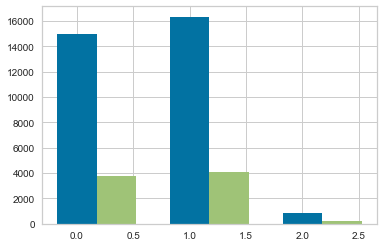

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0)
classes_test = ClassBalance(
    labels=['Entire home/apt', 'Private room', 'Shared room'])
classes_test.fit(y_train['Response'], y_test['Response'])

We split the data set into 80% Train and 20% Test. The bar graph above shows the split by level of our response variable room type. Its good to note that 'Shared room' has a small number of observations compared to the other two classes.

### Data Transforms
- One Hot Encode all categoricals
- Standard Scale all numerics (sklearn is not R - it does not do this by default)
- This needs to be done on train/test set separately (create a pipeline) 

https://scikit-learn.org/stable/modules/cross_validation.html

https://scikit-learn.org/stable/modules/compose.html#combining-estimators

In [11]:
#OH encode
label_encode = [
    x for x, y in dict(X_train.dtypes).items()
    if type(y) == pd.CategoricalDtype
]
for var in label_encode:
    #impute to Mode
    print(f"{var} was OHE'd")
    X_train[var].fillna(X_train[var].mode()[0], inplace=True)
    X_test[var].fillna(X_train[var].mode()[0], inplace=True)
    cat_list_train = pd.get_dummies(X_train[var], prefix=var)
    cat_list_test = pd.get_dummies(X_test[var], prefix=var)
    X_train_new = X_train.join(cat_list_train)
    X_train = X_train_new
    X_test_new = X_test.join(cat_list_test)
    X_test = X_test_new

normalize = [x for x, y in dict(X_train.dtypes).items() if y == np.float64]
for col in normalize:
    #change impution scheme?
    print(f"{col} was Standard Scaled")
    X_train[col].fillna(X_train[col].median(), inplace=True)
    X_test[col].fillna(X_train[col].median(), inplace=True)
    normalizer = StandardScaler()
    ar_train = X_train[col].to_numpy().reshape(-1, 1)
    normalizer.fit(ar_train)
    X_train.loc[:, col] = normalizer.transform(ar_train)
    ar_test = X_test[col].to_numpy().reshape(-1, 1)
    X_test.loc[:, col] = normalizer.transform(ar_test)

X_train.drop(columns=label_encode, inplace=True)
X_test.drop(columns=label_encode, inplace=True)
X_train.drop(columns=target_col, inplace=True)
X_test.drop(columns=target_col, inplace=True)

neighbourhood_group was OHE'd
latitude was Standard Scaled
longitude was Standard Scaled
price was Standard Scaled
minimum_nights was Standard Scaled
number_of_reviews was Standard Scaled
reviews_per_month was Standard Scaled
calculated_host_listings_count was Standard Scaled
availability_365 was Standard Scaled
dist_subway was Standard Scaled
cnt_all was Standard Scaled
cnt_entire_home was Standard Scaled
cnt_private_room was Standard Scaled
cnt_shared_room was Standard Scaled
avgprice_all was Standard Scaled
avgprice_entire_home was Standard Scaled
avgprice_private_room was Standard Scaled
avgprice_shared_room was Standard Scaled
days_since_last_review was Standard Scaled


D:\Users\William\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [ ]:
1. Explain OHE
2. Explain Missing Imputation
3. Explain normalization

### Baseline Accuracy

In [12]:
base_line_accuracy_train = {
    'class_0': (y_train[y_train.Response == 0].shape[0] / y_train.shape[0]),
    'class_1': (y_train[y_train.Response == 1].shape[0] / y_train.shape[0]),
    'class_2': (y_train[y_train.Response == 2].shape[0] / y_train.shape[0])
}
base_line_accuracy_test = {
    'class_0': (y_test[y_test.Response == 0].shape[0] / y_test.shape[0]),
    'class_1': (y_test[y_test.Response == 1].shape[0] / y_test.shape[0]),
    'class_2': (y_test[y_test.Response == 2].shape[0] / y_test.shape[0])
}

print(base_line_accuracy_train)
print(base_line_accuracy_test)

{'class_0': 0.46599676455948236, 'class_1': 0.5083685913389746, 'class_2': 0.025634644101543057}
{'class_0': 0.4682677949228472, 'class_1': 0.5068442010950722, 'class_2': 0.024888003982080638}


We could achieve 50% - 51% accuracy by predicting class 1 all the time (Private room). Hopefully our models do better!

## Logistic Regression

In [28]:
logistic = LogisticRegression(
     max_iter=10000
    ,fit_intercept=True # always fit an intercept term
    ,n_jobs=-1 # use all processors
)
pipe = Pipeline(steps=[('logistic', logistic)])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'logistic__C': np.logspace(-4, 2, 10),
    #'logistic__class_weight':[None, 'balanced'],
    'logistic__penalty':['l1', 'l2'],
    #'logistic__multi_class':['auto', 'ovr', 'multinomial'],
    #'logistic__dual':[True, False],
    #'logistic__solver':['lbfgs', 'liblinear', 'sag', 'saga']
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1,error_score=0.0,scoring='accuracy')
search.fit(X_train, y_train.values.ravel())
print("Best parameter (Accuracy score=%0.3f):" % search.best_score_)
print(search.best_params_)
results = pd.DataFrame(search.cv_results_)
results

D:\Users\William\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Best parameter (Accuracy score=0.813):
{'logistic__C': 4.641588833612772, 'logistic__penalty': 'l1'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.215048,0.008605,0.014337,0.004112,0.0001,l1,"{'logistic__C': 0.0001, 'logistic__penalty': '...",0.465982,0.465982,0.466026,0.465997,0.000021,20,0.466004,0.466004,0.465982,0.465997,0.000010
1,0.945215,0.074706,0.015671,0.002056,0.0001,l2,"{'logistic__C': 0.0001, 'logistic__penalty': '...",0.762483,0.761176,0.754807,0.759489,0.003353,19,0.758925,0.759485,0.759496,0.759302,0.000267
2,0.258058,0.039816,0.009002,0.002160,0.000464159,l1,"{'logistic__C': 0.00046415888336127773, 'logis...",0.781988,0.783854,0.776367,0.780737,0.003182,18,0.780111,0.779178,0.782921,0.780737,0.001591
3,1.025430,0.062516,0.009669,0.001246,0.000464159,l2,"{'logistic__C': 0.00046415888336127773, 'logis...",0.788801,0.795614,0.787568,0.790661,0.003538,17,0.793691,0.788744,0.791554,0.791330,0.002026
4,0.366752,0.047722,0.007335,0.000944,0.00215443,l1,"{'logistic__C': 0.002154434690031882, 'logisti...",0.792534,0.795520,0.789621,0.792558,0.002408,16,0.792244,0.790704,0.794074,0.792341,0.001377
5,1.561132,0.124517,0.010670,0.002496,0.00215443,l2,"{'logistic__C': 0.002154434690031882, 'logisti...",0.804200,0.807653,0.805021,0.805625,0.001473,15,0.807737,0.805124,0.805973,0.806278,0.001088
6,0.719693,0.097991,0.008003,0.001416,0.01,l1,"{'logistic__C': 0.01, 'logistic__penalty': 'l1'}",0.809519,0.810639,0.807075,0.809078,0.001488,14,0.809837,0.808111,0.810359,0.809436,0.000961
7,2.297295,0.095595,0.016004,0.006379,0.01,l2,"{'logistic__C': 0.01, 'logistic__penalty': 'l2'}",0.810079,0.812039,0.808848,0.810322,0.001314,13,0.810770,0.809137,0.810779,0.810229,0.000772
8,1.548125,0.034432,0.012336,0.002623,0.0464159,l1,"{'logistic__C': 0.046415888336127774, 'logisti...",0.811853,0.813066,0.811275,0.812064,0.000746,12,0.811610,0.810957,0.812692,0.811753,0.000716
9,3.126686,0.153221,0.013332,0.003399,0.0464159,l2,"{'logistic__C': 0.046415888336127774, 'logisti...",0.811666,0.813626,0.811275,0.812189,0.001028,11,0.812684,0.811004,0.812832,0.812173,0.000829


In [14]:
results.info()
results.mean_test_score.describe()

results2 = results[results.mean_test_score > 0].copy()
results2.info()
results2.mean_test_score.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_fit_time            40 non-null     float64
 1   std_fit_time             40 non-null     float64
 2   mean_score_time          40 non-null     float64
 3   std_score_time           40 non-null     float64
 4   param_logistic__C        40 non-null     object 
 5   param_logistic__penalty  40 non-null     object 
 6   params                   40 non-null     object 
 7   split0_test_score        40 non-null     float64
 8   split1_test_score        40 non-null     float64
 9   split2_test_score        40 non-null     float64
 10  mean_test_score          40 non-null     float64
 11  std_test_score           40 non-null     float64
 12  rank_test_score          40 non-null     int32  
 13  split0_train_score       40 non-null     float64
 14  split1_train_score       40 

count    20.000000
mean      0.789956
std       0.077457
min       0.465997
25%       0.808673
50%       0.812827
75%       0.812998
max       0.812998
Name: mean_test_score, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


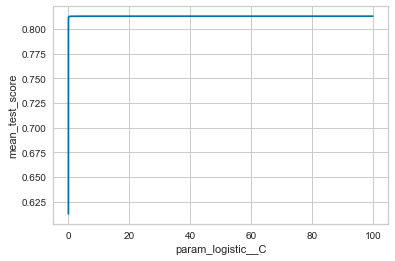

In [39]:
results2 = results[results.mean_test_score > 0]
#sns.set(style='darkgrid')
p1a = sns.lineplot(x="param_logistic__C", y="mean_test_score", data=results2, ci=None)


print(p1a)


[(0, 0.5)]


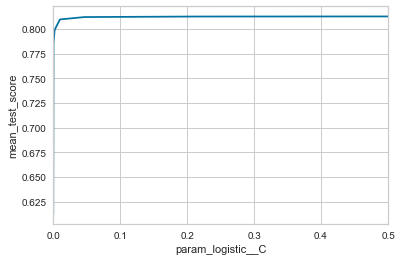

In [38]:
p1b = sns.lineplot(x="param_logistic__C", y="mean_test_score", data=results2, ci=None).set(xlim=(0,0.5))
print(p1b)

AxesSubplot(0.125,0.125;0.775x0.755)


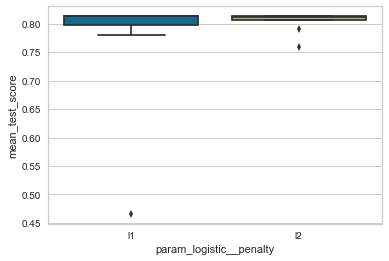

In [30]:
p2 = sns.boxplot(x="param_logistic__penalty", y="mean_test_score", data=results2)
print(p2)

In [31]:
np.logspace(-4, 2, 10)

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

## Support Vector Machine

In [41]:
from sklearn.svm import SVC
?SVC

In [45]:
### THIS TAKES LIKE 2 HOURS to RUN

param_grid_svm = {
    'C': np.logspace(-4, 1, 10),
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}
#search = GridSearchCV(SVC(), param_grid_svm, n_jobs=-1,error_score=0.0,scoring='accuracy')
#search.fit(X_train, y_train.values.ravel())
#print("Best parameter (Accuracy score=%0.3f):" % search.best_score_)
#print(search.best_params_)
#results = pd.DataFrame(search.cv_results_)
#results

Best parameter (Accuracy score=0.849):
{'C': 2.782559402207126, 'gamma': 0.1, 'kernel': 'rbf'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,102.409490,0.494425,18.779954,3.107499,0.0001,0.001,linear,"{'C': 0.0001, 'gamma': 0.001, 'kernel': 'linear'}",0.753990,0.753896,0.749207,0.752364,0.002233,59,0.752905,0.752252,0.752123,0.752427,0.000342
1,150.732266,12.094761,22.948858,1.445845,0.0001,0.001,rbf,"{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}",0.508353,0.508353,0.508400,0.508369,0.000022,69,0.508376,0.508376,0.508353,0.508369,0.000011
2,100.980295,2.433681,18.726123,3.601087,0.0001,0.01,linear,"{'C': 0.0001, 'gamma': 0.01, 'kernel': 'linear'}",0.753990,0.753896,0.749207,0.752364,0.002233,59,0.752905,0.752252,0.752123,0.752427,0.000342
3,156.507479,10.535844,23.899705,1.989890,0.0001,0.01,rbf,"{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}",0.508353,0.508353,0.508400,0.508369,0.000022,69,0.508376,0.508376,0.508353,0.508369,0.000011
4,102.933452,2.290591,18.497560,3.138549,0.0001,0.1,linear,"{'C': 0.0001, 'gamma': 0.1, 'kernel': 'linear'}",0.753990,0.753896,0.749207,0.752364,0.002233,59,0.752905,0.752252,0.752123,0.752427,0.000342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,48.131950,1.342606,4.807163,0.068915,10,0.01,rbf,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.850117,0.850210,0.846463,0.848930,0.001745,2,0.854403,0.854590,0.856136,0.855043,0.000777
76,231.484077,72.114267,2.275561,0.482692,10,0.1,linear,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'linear'}",0.814746,0.815212,0.813795,0.814584,0.000590,12,0.815810,0.815250,0.815772,0.815611,0.000255
77,79.155556,4.080542,4.576668,0.320526,10,0.1,rbf,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}",0.849090,0.845824,0.844503,0.846472,0.001928,4,0.905875,0.907042,0.907326,0.906748,0.000628
78,202.432002,60.133640,2.288563,0.530331,10,1,linear,"{'C': 10.0, 'gamma': 1, 'kernel': 'linear'}",0.814746,0.815212,0.813795,0.814584,0.000590,12,0.815810,0.815250,0.815772,0.815611,0.000255


In [56]:
#import pickle as pickle
#with open('svm_search.pkl', 'wb') as output:
#    pickle.dump(search, output, pickle.HIGHEST_PROTOCOL)


In [58]:
import pickle as pickle
with open('svm_search.pkl', 'rb') as input:
    search = pickle.load(input)
print("Best parameter (Accuracy score=%0.3f):" % search.best_score_)
print(search.best_params_)
results = pd.DataFrame(search.cv_results_)
results

Best parameter (Accuracy score=0.849):
{'C': 2.782559402207126, 'gamma': 0.1, 'kernel': 'rbf'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,102.409490,0.494425,18.779954,3.107499,0.0001,0.001,linear,"{'C': 0.0001, 'gamma': 0.001, 'kernel': 'linear'}",0.753990,0.753896,0.749207,0.752364,0.002233,59,0.752905,0.752252,0.752123,0.752427,0.000342
1,150.732266,12.094761,22.948858,1.445845,0.0001,0.001,rbf,"{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}",0.508353,0.508353,0.508400,0.508369,0.000022,69,0.508376,0.508376,0.508353,0.508369,0.000011
2,100.980295,2.433681,18.726123,3.601087,0.0001,0.01,linear,"{'C': 0.0001, 'gamma': 0.01, 'kernel': 'linear'}",0.753990,0.753896,0.749207,0.752364,0.002233,59,0.752905,0.752252,0.752123,0.752427,0.000342
3,156.507479,10.535844,23.899705,1.989890,0.0001,0.01,rbf,"{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}",0.508353,0.508353,0.508400,0.508369,0.000022,69,0.508376,0.508376,0.508353,0.508369,0.000011
4,102.933452,2.290591,18.497560,3.138549,0.0001,0.1,linear,"{'C': 0.0001, 'gamma': 0.1, 'kernel': 'linear'}",0.753990,0.753896,0.749207,0.752364,0.002233,59,0.752905,0.752252,0.752123,0.752427,0.000342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,48.131950,1.342606,4.807163,0.068915,10,0.01,rbf,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.850117,0.850210,0.846463,0.848930,0.001745,2,0.854403,0.854590,0.856136,0.855043,0.000777
76,231.484077,72.114267,2.275561,0.482692,10,0.1,linear,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'linear'}",0.814746,0.815212,0.813795,0.814584,0.000590,12,0.815810,0.815250,0.815772,0.815611,0.000255
77,79.155556,4.080542,4.576668,0.320526,10,0.1,rbf,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}",0.849090,0.845824,0.844503,0.846472,0.001928,4,0.905875,0.907042,0.907326,0.906748,0.000628
78,202.432002,60.133640,2.288563,0.530331,10,1,linear,"{'C': 10.0, 'gamma': 1, 'kernel': 'linear'}",0.814746,0.815212,0.813795,0.814584,0.000590,12,0.815810,0.815250,0.815772,0.815611,0.000255


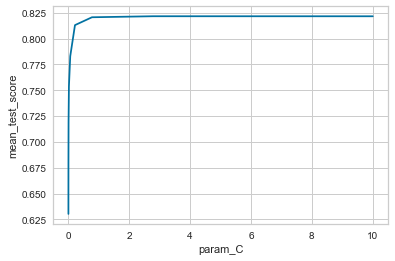

In [50]:
results2 = results[results.mean_test_score > 0]
#sns.set(style='darkgrid')
p1a = sns.lineplot(x="param_C", y="mean_test_score", data=results2, ci=None)

AxesSubplot(0.125,0.125;0.775x0.755)


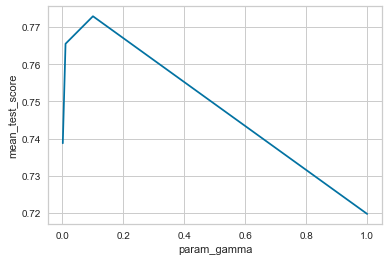

In [52]:
p2 = sns.lineplot(x="param_gamma", y="mean_test_score", data=results2, ci=None)
print(p2)

AxesSubplot(0.125,0.125;0.775x0.755)


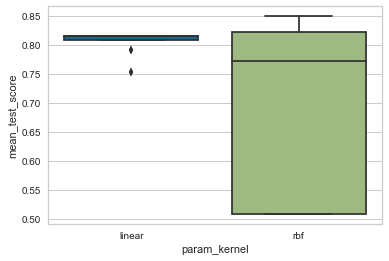

In [51]:
p3 = sns.boxplot(x="param_kernel", y="mean_test_score", data=results2)
print(p3)

<a id="ModelAdvantages"></a>
# Model Advantages

[10] Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

<a id="InterpretFeatureImportance"></a>
# Interpret Feature Importance

[30] Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

<a id="InterpretSupportVectors"></a>
# Interpret Support Vectors

[10] Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

<a id="Conclusion"></a>
# Conclusion

In [17]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#